In [1]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load data

In [2]:
y = pd.read_csv('data/y.csv').iloc[:, 0]
FS1 = pd.read_csv('data/FS1.csv', dtype=float)
PS2 = pd.read_csv('data/PS2.csv', dtype=float)

Reduce dim?

In [3]:
def reduce_time_resolution(df, stride):
    if stride == 1:
        return df
    
    df_reduced = []
    for i in range(0, df.shape[1], stride):
        df_reduced.append(df.iloc[:, i:i+stride].mean(axis=1))

    df_reduced = pd.concat(df_reduced, axis=1)
    # cast col names to str, otherwise sklearn classifier is not happy since we mix int and str col names
    df_reduced.columns = [str(i) for i in range(1, df_reduced.shape[1]+1)]

    return df_reduced

In [4]:
FS1 = reduce_time_resolution(FS1, stride=50)
PS2 = reduce_time_resolution(PS2, stride=500)

In [5]:
FS1.shape, PS2.shape

((2205, 12), (2205, 12))

Train/test split: first 2k samples will be used for the training, rest for the test.

In [6]:
n = 2000

y_train = y.iloc[:n]
FS1_train = FS1.iloc[:n, :]
PS2_train = PS2.iloc[:n, :]

y_test = y.iloc[n:]
FS1_test = FS1.iloc[n:, :]
PS2_test = PS2.iloc[n:, :]

Check data distribution in training and test sets:

In [7]:
pd.concat(
    [
        y.value_counts(normalize=True).rename('all'), 
        y_train.value_counts(normalize=True).rename('train'), 
        y_test.value_counts(normalize=True).rename('test')
    ]
    , axis=1).round(2)

,all,train,test
valve condition,,,
1,0.51,0.53,0.36
0,0.49,0.47,0.64


## Merge all features

Yes

In [8]:
def merge_features(df1, df2):
    return pd.merge(df1, df2, left_index=True, right_index=True)

X_train = merge_features(FS1_train, PS2_train)
X_test = merge_features(FS1_test, PS2_test)

No

In [9]:
# X_train = FS1_train
# X_test = FS1_test

# X_train = PS2_train
# X_test = PS2_test

# Base model

## Choice of the evaluation metric

Since the dataset is well balanced we could start with simple accuracy, precision or recall. Let's start with acuracy.

Check that

## Model

### Logistic regression

In [10]:
clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=0))

In [11]:
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=0))])

In [12]:
y_hat_train = clf.predict(X_train)
y_hat_train

array([1, 1, 1, ..., 0, 0, 0])

In [13]:
(y_hat_train - y_train).mean()

0.0

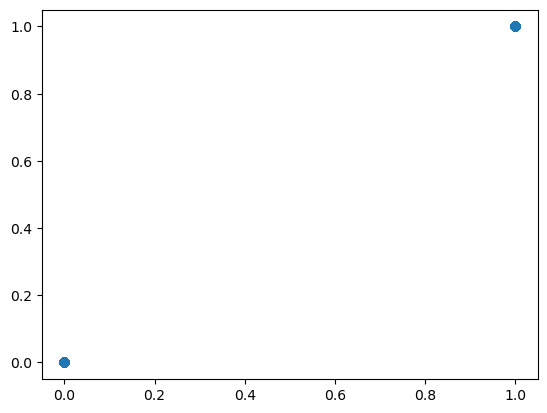

In [14]:
plt.scatter(y_train, y_hat_train)

In [15]:
clf.score(X_train, y_train)

1.0

In [16]:
clf.score(X_test, y_test)

1.0

In [27]:
clf['logisticregression'].coef_

array([[ 5.28449602e-01, -4.33436444e-02, -7.86287722e-01,
         1.15675976e+00,  9.57465871e-03,  1.73949368e-01,
         2.01581799e-01,  1.56582475e-01,  1.04449183e-01,
         2.88502014e-01,  6.02020197e-01,  5.51892733e-01,
        -4.38743227e-01,  1.07097251e+01, -9.04916889e-01,
        -3.23054934e-01,  4.27907274e-01,  4.51151857e-01,
         2.33727492e-01,  1.96935472e-01,  2.50186990e-01,
         2.97598965e-01,  5.52431483e-01,  5.85998203e-01]])

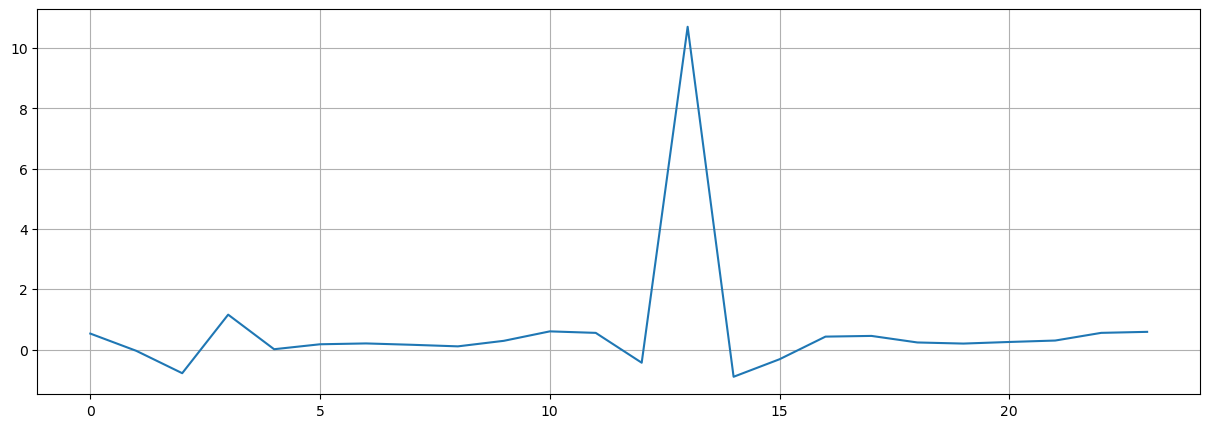

In [39]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(clf['logisticregression'].coef_[0])
ax.grid()

In [22]:
clf['logisticregression'].intercept_

array([-4.57013944])

In [61]:
X_train.to_numpy().shape

(2000, 24)

In [43]:
clf['logisticregression'].coef_.shape

(1, 24)

In [51]:
import numpy as np

v = np.array([[1, 2]])
m = np.array([[1, 2], [3, 4], [5, 6]])

v @ m.T

array([[ 5, 11, 17]])

In [59]:
clf['logisticregression'].coef_ @ clf['standardscaler'].transform(X_train).T

array([[ 8.43870536,  8.26146254,  8.13010229, ..., -7.65535084,
        -9.18931038, -8.3102679 ]])

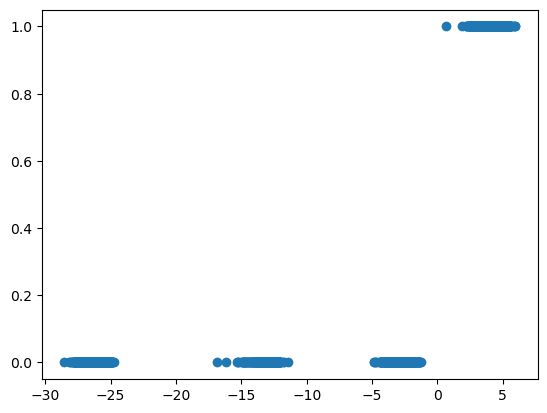

In [62]:
plt.scatter(clf['logisticregression'].coef_ @ clf['standardscaler'].transform(X_train).T + clf['logisticregression'].intercept_, y_train)

In [65]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'LR coef': clf['logisticregression'].coef_[0]})
feature_importance

,feature,LR coef
0,1_x,0.528450
1,2_x,-0.043344
2,3_x,-0.786288
3,4_x,1.156760
4,5_x,0.009575
5,6_x,0.173949
6,7_x,0.201582
7,8_x,0.156582
8,9_x,0.104449
9,10_x,0.288502


<Axes: xlabel='feature'>

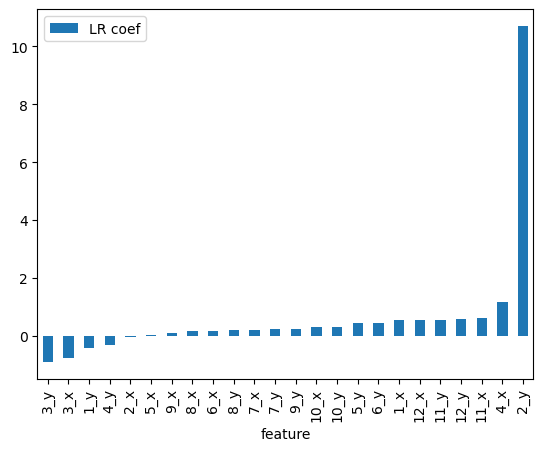

In [72]:
feature_importance.sort_values(by=['LR coef']).plot.bar(x='feature', y='LR coef')

<Axes: xlabel='feature'>

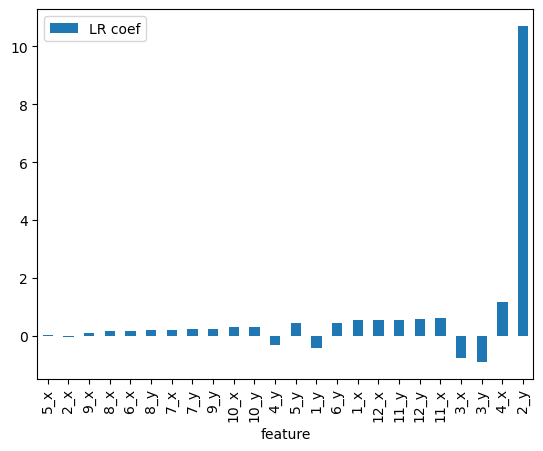

In [73]:
feature_importance['LR coef abs'] = feature_importance['LR coef'].abs()

feature_importance.sort_values(by=['LR coef abs']).plot.bar(x='feature', y='LR coef')

Feature correlations

In [75]:
X_train.corr()

,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,...,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y
1_x,1.000000,-0.071392,0.261099,-0.325522,-0.329764,-0.323179,-0.321818,-0.325060,-0.324986,-0.292947,...,-0.113654,0.008415,0.351272,0.353577,0.349683,0.348781,0.346914,0.346633,-0.045797,-0.048309
2_x,-0.071392,1.000000,-0.488360,0.227440,0.148051,0.149073,0.152821,0.153695,0.152152,0.151662,...,-0.072194,-0.039293,-0.137064,-0.137976,-0.144713,-0.145024,-0.143337,-0.145931,-0.024574,-0.021949
3_x,0.261099,-0.488360,1.000000,0.264671,0.268545,0.277409,0.287457,0.285530,0.283114,0.314542,...,0.504545,0.343756,-0.189686,-0.187541,-0.186474,-0.190133,-0.208144,-0.194209,0.154238,0.150287
4_x,-0.325522,0.227440,0.264671,1.000000,0.948673,0.949772,0.932171,0.931753,0.931516,0.923436,...,0.422563,0.041381,-0.920788,-0.920660,-0.899628,-0.901766,-0.906605,-0.901194,0.074754,0.079205
5_x,-0.329764,0.148051,0.268545,0.948673,1.000000,0.999236,0.974055,0.974045,0.974093,0.965072,...,0.488456,0.045170,-0.987210,-0.986433,-0.954834,-0.956534,-0.962203,-0.955187,0.083627,0.086570
6_x,-0.323179,0.149073,0.277409,0.949772,0.999236,1.000000,0.981504,0.981338,0.981451,0.973294,...,0.498935,0.058317,-0.983765,-0.983521,-0.960117,-0.961929,-0.967939,-0.960870,0.083332,0.086203
7_x,-0.321818,0.152821,0.287457,0.932171,0.974055,0.981504,1.000000,0.999916,0.999955,0.993680,...,0.503394,0.078680,-0.953880,-0.957057,-0.979436,-0.981193,-0.987134,-0.981355,0.061850,0.064725
8_x,-0.325060,0.153695,0.285530,0.931753,0.974045,0.981338,0.999916,1.000000,0.999918,0.993431,...,0.498386,0.072531,-0.954911,-0.958154,-0.980710,-0.982387,-0.988122,-0.982512,0.059485,0.062405
9_x,-0.324986,0.152152,0.283114,0.931516,0.974093,0.981451,0.999955,0.999918,1.000000,0.993402,...,0.500087,0.074757,-0.954811,-0.958032,-0.980536,-0.982250,-0.988035,-0.982368,0.060412,0.063316
10_x,-0.292947,0.151662,0.314542,0.923436,0.965072,0.973294,0.993680,0.993431,0.993402,1.000000,...,0.515245,0.093936,-0.941158,-0.944292,-0.968517,-0.970435,-0.977091,-0.976472,-0.028035,-0.025719


In [76]:
import seaborn as sns

In [77]:
corrs = X_test.corr('pearson')

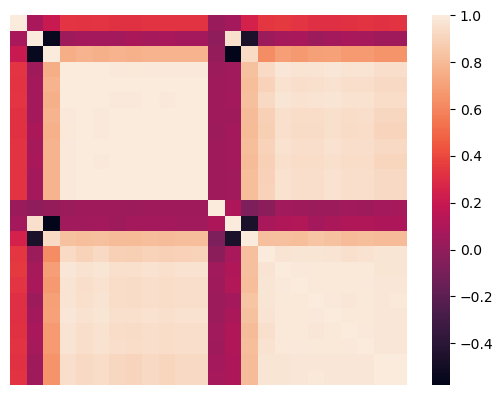

In [78]:
sns.heatmap(corrs, annot=False, xticklabels=False, yticklabels=False);

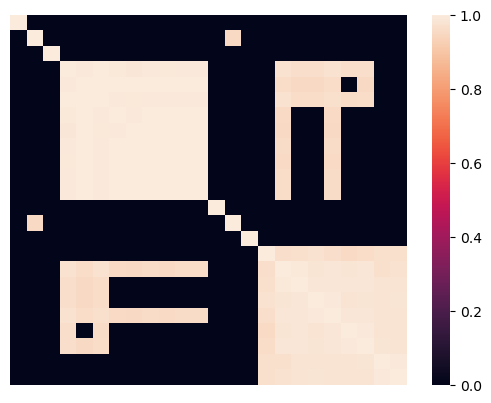

In [81]:
corrs_abs = corrs.abs()
corrs_abs[corrs_abs < 0.95] = 0

sns.heatmap(corrs_abs, annot=False, xticklabels=False, yticklabels=False);